In [4]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
import seaborn as sns
sns.set_style("white")
from matplotlib.colors import LogNorm

HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
DATAPATH="/storage/mgymrek/ssc-imputation/callstats/"
PCAFILE="/storage/s1saini/ssc-pca/pca_10.eigenvec"
ONEKGPOP="/home/mgymrek/workspace/ssc-imputation/denovos2/other_data/1000GenomesPopulations.csv"
SSCFAMS="/home/mgymrek/workspace/ssc-imputation/metadata/ssc_family_ids.txt"
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}

OUTPATH="pdfs/"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 500 # Min number of 1000G calls to include in heterozygosity comparison
NUMSAMPLES=1916

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load info

In [6]:
locstats = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_locstats.tab"), sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)
locstats["length"] = locstats["end"]-locstats["start"]+1

In [6]:
sampstats = pd.read_fwf(os.path.join(DATAPATH, "ssc_hipstr_sampstats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

In [4]:
mend = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_mendstats.tab"), sep="\t", nrows=1000000)
mend["mend"] = mend["mend"].apply(int)
mend["chrom"] = mend["chrom"].apply(str)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
mend = mend[~mend["homref"]]
mend = pd.merge(mend, locstats[["chrom","start","end","FILTER"]], on=["chrom","start"])

# Figure 1B: Calls/sample

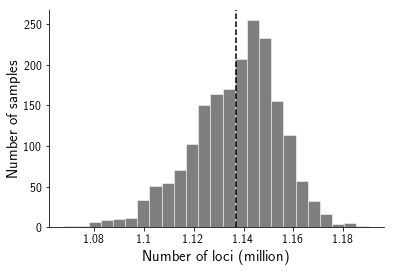

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25, alpha=0.5);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci (million)", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([(x)/10**6 for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(x=np.mean(sampstats["numloci"]), color="black", linestyle="dashed")
fig.savefig(os.path.join(OUTPATH, "Figure1_LociPerSample.pdf"))

In [7]:
# Average calls/sample
np.mean(sampstats["numloci"])

1136915.9185803758

# Figure 1C: Call rate per locus

In [8]:
locstats_all = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats_all.ix[np.isnan(locstats_all["numcalls"]), "numcalls"] = 0
counts, bins = np.histogram(locstats["numcalls"], bins=25)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


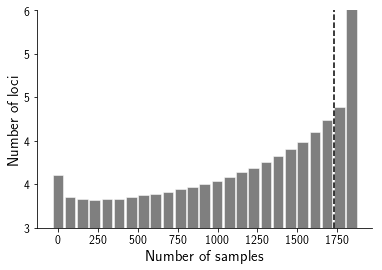

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
# Merge with hipstr reference so we get loci with 0 calls
ax.bar(bins[:-1], np.log10(counts), color="black", width=(bins[1]-bins[0])/1.15, edgecolor="white", alpha=0.5);
ax.set_ylim(bottom=3.5, top=6);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(np.mean(locstats["numcalls"]), color="black", linestyle="dashed")
fig.savefig(os.path.join(OUTPATH, "Figure1_SamplesPerLocus.pdf"))

In [10]:
# Overall call rate
1-locstats_all[locstats_all["numcalls"]==0].shape[0]/locstats_all.shape[0]

0.9672751846967255

In [11]:
# Average call rate
np.mean(locstats["numcalls"])/NUMSAMPLES

0.9037484045372617

In [12]:
# Loci remaining after filtering
locstats[locstats["FILTER"]=="."].shape[0]

453671

# Figure 1D: Mendelian inheritance

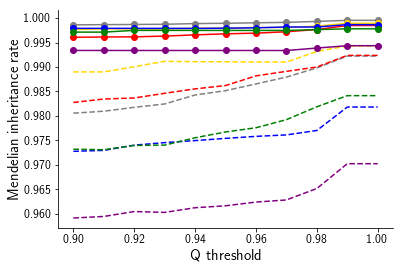

In [42]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.9, 1.1, 0.01)

mend_pass = mend[(mend["FILTER"]==".")]
mend_fail = mend[(mend["FILTER"]!=".")]

for period in range(1, 7):
    mend_scores_pass = []
    mend_scores_fail = []
    for q in scores:
        x_pass = mend_pass[(mend_pass["Q"]>=q) & (mend_pass["period"]==period)]
        if x_pass.shape[0] >= 50:
            mend_scores_pass.append(np.mean(x_pass["mend"]))
        else: mend_scores_pass.append(np.nan)
        x_fail = mend_fail[(mend_fail["Q"]>=q) & (mend_fail["period"]==period)]
        if x_fail.shape[0] >= 50:
            mend_scores_fail.append(np.mean(x_fail["mend"]))
        else: mend_scores_fail.append(np.nan)
    ax.plot(scores, mend_scores_pass, color=colors[period-1], marker="o");
    ax.plot(scores, mend_scores_fail, color=colors[period-1], linestyle="dashed");
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels(["%.2f"%(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.3f"%(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_MendelianInheritance.pdf"))

In [43]:
# Average Mend. inheritance before filtering 
np.mean(mend_fail["mend"])

0.97864280302488815

In [44]:
# Average Mend. inheritance after filtering 
np.mean(mend_pass["mend"])

0.99782613390151376

# Figure 1E: Comparison to lobSTR heterozygosities

In [7]:
lobstr = pd.read_csv(os.path.join(DATAPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: str(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]
het = pd.merge(lobstr, locstats[["chrom","start","het","FILTER"]], on=["chrom","start"])
het = het[(het["FILTER"]==".") | (het["FILTER"]=="Het")]

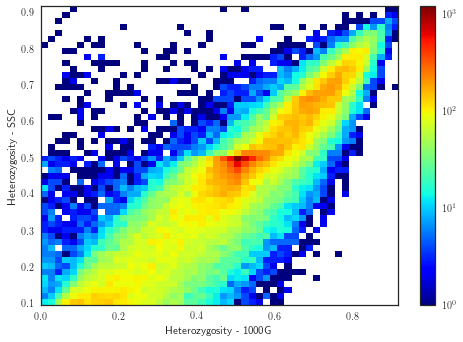

In [14]:
x = het[het["het"]>0.095]["het_lobstr"]
y = het[het["het"]>0.095]["het"]
plt.hist2d(x, y, bins=50, norm=LogNorm(), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("Heterozygosity - 1000G")
plt.ylabel("Heterozygosity - SSC")
plt.savefig(os.path.join(OUTPATH, "Figure1_Heterozygosities.pdf"));

In [47]:
# Correlation with lobSTR heterozygosities
r, p = scipy.stats.pearsonr(het["het_lobstr"], het["het"])
print("\t".join([str(item) for item in [r, p, het.shape[0]]]))

0.955498900848	0.0	386100


# Supplemental Figure: SSC Populations

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:62: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


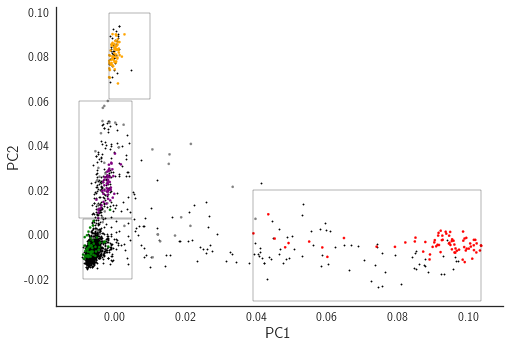

In [35]:
import matplotlib.patches as patches

# Load PCA results
pca = pd.read_csv(PCAFILE, sep=" ",
                 names=["sample","sample2"]+["pc%s"%i for i in range(1,11)])
# Load 1kg population labels
onekg = pd.read_csv(ONEKGPOP)

# Load pedigree info
ped = pd.read_csv(SSCFAMS, sep="\t", names=["id","sample"])
ped["family"] = ped["id"].apply(lambda x: x.split(".")[0])
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])

# Merge final data
data = pd.merge(pca, onekg, on="sample", how="left")
data = pd.merge(data, ped[["family","rel","sample"]], on="sample", how="left")

# Plot PCA to get boundaries
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}
refdata = data[(data["Population"].apply(lambda x: str(x) != "nan"))]
refdata["color"] = refdata.apply(lambda x: POPCOLORS.get(x["Superpop"],"gray"), 1)
ssc = data[(data["Population"].apply(lambda x: str(x) == "nan"))]
ssc = pd.merge(ssc, sampstats, on=["sample"])
ssc["Superpop"] = "NA"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ssc["pc1"], ssc["pc2"], color="black", s=2);
ax.scatter(refdata["pc1"], refdata["pc2"], color=list(refdata["color"]), s=5);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15);

# Get population boundaries
for popname in ["EAS","AFR","SAS","EUR"]:
    pop = refdata[refdata["Superpop"]==popname]
    max_pc1 = max(pop["pc1"])
    min_pc1 = min(pop["pc1"])
    max_pc2 = max(pop["pc2"])
    min_pc2 = min(pop["pc2"])
    if popname == "EUR":
        max_pc1 = 0.005
        min_pc2 = -0.02
        max_pc2 = 0.007
    if popname == "AFR":
        min_pc2 = -0.03
        max_pc2 = 0.02
    if popname == "SAS":
        max_pc2 = 0.06
        min_pc1 = -0.01
        max_pc1 = 0.005
        min_Pc2 = 0.008
    if popname == "EAS":
        min_pc2 = 0.061
        max_pc2 = 0.1
        max_pc1 = 0.01
    ssc_pop = ssc[(ssc["pc1"]>=min_pc1) & (ssc["pc1"]<=max_pc1) &
                 (ssc["pc2"]>=min_pc2) & (ssc["pc2"]<=max_pc2)]
    ssc.ix[ssc["sample"].apply(lambda x: x in ssc_pop["sample"].values),"Superpop"] = popname
    ax.add_patch(
        patches.Rectangle(
        (min_pc1, min_pc2),
        max_pc1-min_pc1,
        max_pc2-min_pc2,
        fill=False
        ))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15)
ax.set_xticklabels(["%.2f"%x for x in ax.get_xticks()], size=12);
ax.set_yticklabels(["%.2f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_PopPCA.pdf"));

In [36]:
# Get count by population group
y = ssc.groupby("Superpop", as_index=False).agg({"sample": len})
y["perc"] = y["sample"].apply(lambda x: x*1.0/sum(y["sample"]))
y

,Superpop,sample,perc
0,AFR,69,0.036013
1,EAS,39,0.020355
2,EUR,1585,0.827244
3,NA,51,0.026618
4,SAS,172,0.089770


# Supplemental Figure: Length bias

In [48]:
reflen = range(10, 100, 1)
diffs = []
percs = []
for i in range(len(reflen)-1):
    lb = reflen[i]
    ub = reflen[i+1]
    x = locstats[(locstats["length"]>=lb) & (locstats["length"]<ub)]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else:
        diffs.append(sum(x.apply(lambda x: x["mean_allele"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<ub].shape[0]*1.0/locstats.shape[0])

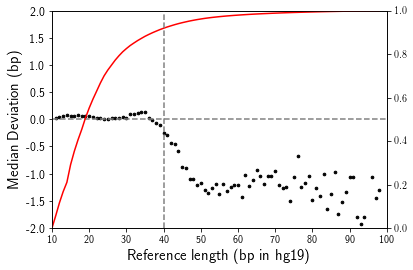

In [49]:
xmax = 100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen[:-1], diffs, color="black", s=7);
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Median Deviation (bp)", size=15)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=10, right=xmax)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")

ax2 = ax.twinx()
ax2.plot(reflen[:-1], percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=xmax)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax2.axvline(x=40, linestyle="dashed", color="gray")
fig.savefig(os.path.join(OUTPATH, "SuppFig_LengthBias.pdf"));